# Argon A-to-Z

This tutorial demonstrates a-to-z how to optimise Lennard Jones parameters for liquid argon, and without going into details. For details see other tutorials and wider MDMC documentation.

In [1]:
# Imports used for this tutorial
import numpy as np
import os
from MDMC.control import Control
from MDMC.MD import Atom, Dispersion, LennardJones, Simulation, Universe

Supported DL_POLY version 5.0


In [2]:
# Change the number of threads depending on the number of physical cores on your computer
# as it was tested for LAMMPS
os.environ["OMP_NUM_THREADS"] = "4"

In [3]:
# Build universe with density 0.0176 atoms per AA^-3
density = 0.0176
# This means cubic universe of side:
# 23.0668 A will contain 216 Ar atoms
# 26.911 A will contain 343 Ar atoms
# 30.7553 A will contain 512 Ar atoms
# 38.4441 A will contain 1000 Ar atoms
universe = Universe(dimensions=23.0668)
Ar = Atom('Ar', charge=0., mass=36.0)
# Calculating number of Ar atoms needed to obtain density
n_ar_atoms = int(density * np.product(universe.dimensions))
print(f'Number of argon atoms = {n_ar_atoms}')
universe.fill(Ar, num_struc_units=(n_ar_atoms))

Universe created with:
  Dimensions       [23.07, 23.07, 23.07]
  Force field                       None
  Number of atoms                      0

Number of argon atoms = 216


In the Jupyter cell above, a box of Argon atoms is set up. However, at this point there is no interaction forces between the argon atoms! In the cell below an appropriate (for argon) force-field interaction potential is defined.

In [4]:
Ar_dispersion = Dispersion(universe,
                           (Ar.atom_type, Ar.atom_type),
                           cutoff=8.,
                           function=LennardJones(epsilon=1.0243, sigma=3.36))

In this case the interaction potential chosen is the humble Lennard Jones (to get info see doc or type `help(LennardJones)`).

Also, a `cutoff` value is chosen (see `help(Dispersion)` for more info). A [rule of thumb for Lennard-Jones](https://en.wikipedia.org/wiki/Lennard-Jones_potential) is to pick `cutoff=2.5*sigma`. The value for argon is recommended to be between 8 and 12 ang. `cutoff` is not a force-field parameter and therefore will not be refined. Ideally, and for any system you want to pick at value of the `cutoff` which is small while not compromising accuracy. For this system picking a value between 8 and 12 ang is found to give near identifical results.

Next (and before starting the refinement), we set up the MD engine and equilibrate the system. Note with MDMC the equilibration only needs to be done once. 

In [5]:
# MD Engine setup
simulation = Simulation(universe,
                        engine="lammps",
                        time_step=10.18893,
                        temperature=120.,
                        traj_step=15)

LAMMPS (29 Sep 2021 - Update 3)
  using 4 OpenMP thread(s) per MPI task
LAMMPS output is captured by PyLammps wrapper
LAMMPS (29 Sep 2021 - Update 3)
  using 4 OpenMP thread(s) per MPI task
LAMMPS output is captured by PyLammps wrapper
Total wall time: 0:00:00
using multi-threaded neighbor list subroutines


Simulation created with lammps engine and settings:
  temperature  120.0



In [6]:
# Energy Minimization and equilibration
simulation.minimize(n_steps=50)
simulation.run(n_steps=10000, equilibration=True)

OK; time to set up the actual refinement of the force-field parameters. 

First we need some data to refine against:

In [7]:
# exp_datasets is a list of dictionaries with one dictionary per experimental
# dataset
# Dataset from: van Well et al. (1985). Physical Review A, 31(5), 3391-3414
# resolution is None as the original author already accounted for instrument resolution
exp_datasets = [{'file_name':'data/Well_s_q_omega_Ar_data.xml',
                 'type':'SQw',
                 'reader':'xml_SQw',
                 'weight':1.,
                 'auto_scale':True,
                 'resolution':7500}]

The number of `MD_steps` specified must be large enough to allow for successful calculation of all observables. This depends the `type` of the dataset provided and the value of the `traj_step` (specified when creating the `Simulation`). If a value for `MD_steps` is not provided, then the minimum number needed will be used automatically.

Additionally, some observables will have an upper limit on the number of MD_steps that can be used in calculating their dependent variable(s). In these cases, the number of `MD_steps` is rounded down to a multiple of this upper limit so that we only run steps that will be useful. For example, if we use 1000 `MD_steps` in calculation, but a value of 2500 is provided, then we will run 2000 steps and use this to calculate the variable twice, without wasting time performing an additional 500 steps.

In [8]:
fit_parameters = universe.parameters
fit_parameters['sigma'].constraints = [2.8,3.8]
fit_parameters['epsilon'].constraints = [0.6, 1.4]


control = Control(simulation=simulation,
                  exp_datasets=exp_datasets,
                  fit_parameters=fit_parameters,
                  minimizer_type="GPO",
                  reset_config=True,
                  MD_steps=4000, 
                  equilibration_steps=4000)

Control created with:
- Attributes                              -
  Minimizer                             GPO
  FoM type               ChiSquaredExpError
  Number of observables                   1
  Number of parameters                    2



And finally start the refinement! Bump up `n_steps` from 3 when you are ready.

Step         FoM Change state  Pred coords     Pred FoM epsilon (#2)   sigma (#3)


   0        1110     Accepted [1.0243 kJ / mol, 3.36 Ang]         1110        1.024         3.36


   1        1093     Accepted [1.0350755236683686 kJ / mol, 3.532035936386891 Ang]         1093        1.035        3.532


   2        1286     Accepted [1.0350755236683686 kJ / mol, 3.532035936386891 Ang]         1093        1.075        2.905


   3        1051     Accepted [0.9356131020068645 kJ / mol, 3.7824087689280574 Ang]         1051       0.9356        3.782


   4        1097     Accepted [0.9356131020068645 kJ / mol, 3.7824087689280574 Ang]         1051        1.396         3.47


   5        1280     Accepted [0.9356131020068645 kJ / mol, 3.7824087689280574 Ang]         1051       0.7189        2.876


   6        1172     Accepted [0.9356131020068645 kJ / mol, 3.7824087689280574 Ang]         1051       0.9139        3.198


   7        1066     Accepted [0.9356131020068645 kJ / mol, 3.7824087689280574 Ang]         1051       0.8076        3.693


   8        1160     Accepted [0.9356131020068645 kJ / mol, 3.7824087689280574 Ang]         1051       0.6141        3.271


   9        1371     Accepted [0.9356131020068645 kJ / mol, 3.7824087689280574 Ang]         1051        1.174        2.812


  10        1131     Accepted [0.9356131020068645 kJ / mol, 3.7824087689280574 Ang]         1051       0.9896        3.336


  11        1283     Accepted [0.9356131020068645 kJ / mol, 3.7824087689280574 Ang]         1051        1.218        2.966


  12        1250     Accepted [0.9356131020068645 kJ / mol, 3.7824087689280574 Ang]         1051        0.747        3.001


  13        1076     Accepted [0.9356131020068645 kJ / mol, 3.7824087689280574 Ang]         1051       0.7752        3.566


  14        1099     Accepted [0.9356131020068645 kJ / mol, 3.7824087689280574 Ang]         1051        1.141        3.713


  15        1095     Accepted [0.9356131020068645 kJ / mol, 3.7824087689280574 Ang]         1051        0.665        3.619


  16        1222     Accepted [0.9356131020068645 kJ / mol, 3.7824087689280574 Ang]         1051        1.354        3.098


  17        1173     Accepted [0.9356131020068645 kJ / mol, 3.7824087689280574 Ang]         1051        1.304        3.223


  18        1203     Accepted [0.9356131020068645 kJ / mol, 3.7824087689280574 Ang]         1051        1.119        3.104


  19        1097     Accepted [0.9356131020068645 kJ / mol, 3.7824087689280574 Ang]         1051       0.8776        3.441


  20        1072     Accepted [0.9356131020068645 kJ / mol, 3.7824087689280574 Ang]         1051       0.6364        3.799


  21        1073     Accepted [0.9356131020068645 kJ / mol, 3.7824087689280574 Ang]         1051       0.6168          3.8


  22        1077     Accepted [0.9356131020068645 kJ / mol, 3.7824087689280574 Ang]         1051        1.368        3.796


  23        1089     Accepted [0.9356131020068645 kJ / mol, 3.7824087689280574 Ang]         1051       0.6273          3.8


  24        1044     Accepted [1.398996946099505 kJ / mol, 3.7986776172747065 Ang]         1044        1.399        3.799

The refinement has finished. 
 
Minimum measured point is: 
(1.398996946099505 kJ / mol, 3.7986776172747065 Ang) with an FoM of 1044.4615672640332. 
 
Minimum point predicted is: 
(1.398996946099505 kJ / mol, 3.7986776172747065 Ang) for an FoM of 1044.4615672640332.
 
 

Automatic Scale Factors
  data/Well_s_q_omega_Ar_data.xml  0.306101


Parameter means = [1.00608324 3.55564683], Parameter errors = [0.22605792 0.18140947]


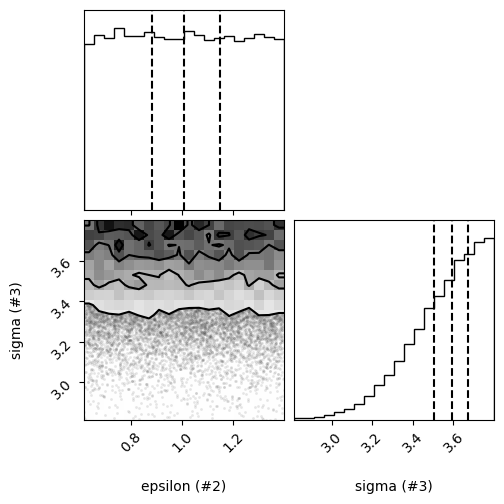

In [9]:
# Run the refinement, i.e. refine the FF parameters against the data
control.refine(n_steps=25)
control.plot_results();